In [82]:
import numpy as np
import pandas as pd
import scipy
import pickle
import flexcode
from flexcode.regression_models import NN

import matplotlib.pyplot as plt
import seaborn as sns
import ipdb

In [259]:
%matplotlib inline

# generate data

### $X \sim Unif(-1,1)$
### $Y \sim 0.5N(X,1) + 0.5N(X,0.01)$

In [83]:
def generate_data(size=1000):
    #X = np.random.uniform(-1, 1, size)
    X = np.random.normal(0, 1, size)
    ind_mix = np.random.binomial(n=1, p=0.5, size=size)
    mix1 = np.random.normal(X, 1)
    mix2 = np.random.normal(X, 0.1)
    Y = ind_mix * mix1 + (1-ind_mix) * mix2
    return X, Y

In [84]:
X, Y = generate_data(size=10000)

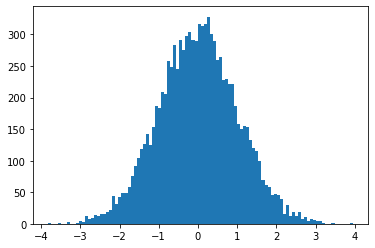

In [85]:
plt.hist(X, bins=100)
plt.show()

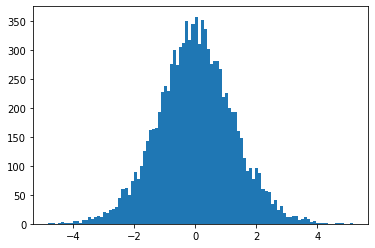

In [86]:
plt.hist(Y, bins=100)
plt.show()

# fit FlexCode CDE

In [87]:
x_train, y_train = generate_data(10000)
x_validation, y_validation = generate_data(10000)
x_test, y_test = generate_data(10000)

In [88]:
model = flexcode.FlexCodeModel(NN, max_basis=31, basis_system="cosine",
                               regression_params={"k":20})

In [89]:
model.fit(x_train, y_train)
model.tune(x_validation, y_validation)

In [90]:
print(model.estimate_error(x_test, y_test))

-0.7962578429264919


In [91]:
cdes, y_grid = model.predict(x_test, n_grid=200)

In [92]:
def cde_truth_example(x_test, y_grid):
    n_x = x_test.shape[0]
    n_y = y_grid.shape[0]
    cdes_out = np.zeros((n_x,n_y))
    for ii in range(n_x):
        cdes_out[ii,] = np.ravel(0.5*scipy.stats.norm.pdf(y_grid, x_test[ii], 1) + \
            0.5*scipy.stats.norm.pdf(y_grid, x_test[ii], 0.1))
    return cdes_out

In [93]:
cdes_truth = cde_truth_example(x_test, y_grid)

In [94]:
print(cdes_truth.shape) 
print(cdes.shape)

(10000, 200)
(10000, 200)


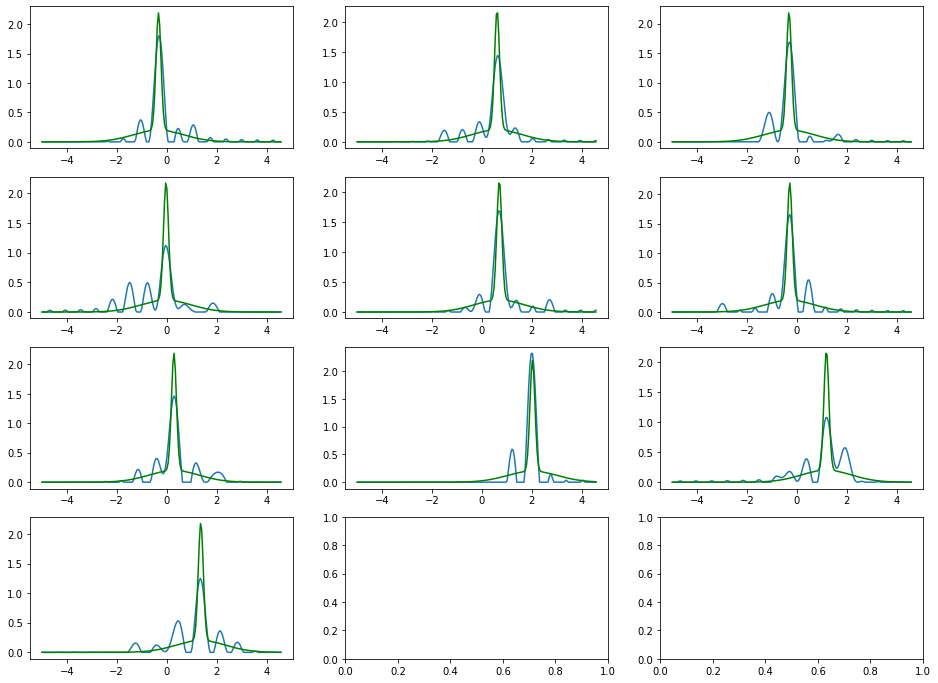

In [248]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (16,12))
ax = ax.ravel()
for ii in range(10):
    true_density = 0.5*scipy.stats.norm.pdf(y_grid, x_test[ii], 1) + 0.5*scipy.stats.norm.pdf(y_grid, x_test[ii], 0.1)
    ax[ii].plot(y_grid, cdes[ii, :])
    ax[ii].plot(y_grid, true_density, color="green")
    #plt.axvline(x=y_test[ii], color="red")
    #plt.show()

# run CDE diagnostics

In [96]:
import numpy as np
import pandas as pd

from cde_diagnostics.local_test import local_test
from cde_diagnostics.global_test import global_test
# from cde_diagnostics.local_pp_plot import local_pp_plot

import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.cde_loss import cde_loss
#from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

In [97]:
pitt_values = 1 - cdf_coverage(cdes, y_grid, y_test)

## HPD approach

In [98]:
def find_interval(grid, value):
    """
    find index that value falls on the grid (assumed ordered)
    """
    if (grid[0] > value) | \
       (grid[grid.shape[0]-1] < value):
        return np.nan
    
    idx = np.sum(grid <= value) - 1 

    return idx

def inner_hpd_value(cdes, z_grid, z_test, z_delta):
    """
    all of these values are for a single x value.
    """
    
    z_idx = find_interval(z_grid, z_test)
    
    if np.isnan(z_idx):
        return 0
    
    v2 = cdes.copy()
    v2_val = cdes[z_idx]
    v2.sort()
    v2s = ((v2.cumsum())*z_delta)
    v2si = v2s[find_interval(v2, v2_val)]
    return v2si

In [99]:
def test_find_interval():
    """test find_interval, basic"""
    
    grid = np.arange(5,10)
    value_na = 4
    value_mid = 7
    value_na2 = 11
    out1 = find_interval(grid, value_na)
    out2 = find_interval(grid, value_mid)
    out3 = find_interval(grid, value_na)
    
    assert np.isnan(out1), \
        "expect value beyond grid to return NA (below)"
    assert np.isnan(out3), \
        "expect value beyond grid to return NA (above)"
    assert out2 == 2,\
        "7 should be in the bin [7,8)"

def test_inner_hpd_value():
    """test inner_hpd_value, basic"""
    cdes = np.array([.09,.24,.3,.26,.11])
    z_grid = np.arange(5.0) + .1
    z_test = 3.1
    z_delta = 1.0
    out1 = inner_hpd_value(cdes, z_grid, z_test, z_delta)
    assert out1 == .7, \
        "error in inner_hpd_value getting desired amount above"
    out2 = inner_hpd_value(cdes, z_grid, 3.2, z_delta)
    assert out2 == .7, \
        "error in inner_hpd_value getting desired amount above"
    
    out3 = inner_hpd_value(cdes, z_grid, 0, z_delta)
    assert out3 == 0, \
        "expected z_values outside the grid to return 0 hpd values (lower)"
    out4 = inner_hpd_value(cdes, z_grid, 6.7, z_delta)
    assert out4 == 0, \
        "expected z_values outside the grid to return 0 hpd values (upper)"
    
test_find_interval()
test_inner_hpd_value()

In [100]:
def hpd_coverage_old(cdes, z_grid, z_test):
    """
    Calculates 'coverage' based upon the HPD
    @param cdes: a numpy array of conditional density estimates;
        each row corresponds to an observation, each column corresponds to a grid
        point
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates
    @returns A numpy array of values
    """
    nrow_cde, ncol_cde = cdes.shape
    n_samples = z_test.shape[0]
    n_grid_points = z_grid.shape[0]

    if nrow_cde != n_samples:
        raise ValueError("Number of samples in CDEs should be the same as in z_test."
                         "Currently %s and %s." % (nrow_cde, n_samples))
    if ncol_cde != n_grid_points:
        raise ValueError("Number of grid points in CDEs should be the same as in z_grid."
                         "Currently %s and %s." % (nrow_cde, n_grid_points))

    z_min = np.min(z_grid)
    z_max = np.max(z_grid)
    z_delta = (z_max - z_min)/(n_grid_points-1)
    
    vals = [inner_hpd_value(cdes[ii, ], z_grid, z_test[ii], z_delta)
            for ii in range(n_samples)]
    return np.array(vals)
    
    

In [101]:
def inner_hpd_value_level(cdes, z_grid, z_test, z_delta, order = None):
    """
    all of these values are for a single x value.
    
    order tells us the ordering the cdes (if not provided) the order
    is calculated as the index ordering the z_grid this values of cdes smallest 
    to largest
    """
    
    z_idx = find_interval(z_grid, z_test)
    
    if np.isnan(z_idx):
        return 0
    v2 = cdes.copy()
    
    if order is None:
        order = v2.argsort()
    
    v2_index = (order == z_idx).argmax()
    
    v2 = v2[order]
    v2s = ((v2.cumsum())*z_delta)
    v2si = v2s[v2_index]
    return v2si

In [102]:
def hpd_coverage(cdes, z_grid, z_test, order = None):
    """
    Calculates 'coverage' based upon the HPD
    @param cdes: a numpy array of conditional density estimates;
        each row corresponds to an observation, each column corresponds to a grid
        point
    @param z_grid: a numpy array of the grid points at which cde_estimates is evaluated
    @param z_test: a numpy array of the true z values corresponding to the rows of cde_estimates
    @returns A numpy array of values
    """
    nrow_cde, ncol_cde = cdes.shape
    n_samples = z_test.shape[0]
    n_grid_points = z_grid.shape[0]

    if nrow_cde != n_samples:
        raise ValueError("Number of samples in CDEs should be the same as in z_test."
                         "Currently %s and %s." % (nrow_cde, n_samples))
    if ncol_cde != n_grid_points:
        raise ValueError("Number of grid points in CDEs should be the same as in z_grid."
                         "Currently %s and %s." % (nrow_cde, n_grid_points))

    z_min = np.min(z_grid)
    z_max = np.max(z_grid)
    z_delta = (z_max - z_min)/(n_grid_points-1)
    
    vals = [inner_hpd_value_level(cdes[ii, ], z_grid, z_test[ii], z_delta,
                                 order)
            for ii in range(n_samples)]
    return np.array(vals)
    

In [103]:
def test_inner_hpd_value_order():
    """test inner_hpd_value_order, basic"""
    cdes = np.array([.09,.24,.3,.26,.11])
    z_grid = np.arange(5.0) + .1
    z_test = 3.1
    z_delta = 1.0
    
    
    # Original
    out1 = inner_hpd_value_level(cdes, z_grid, z_test, z_delta)
    assert out1 == .7, \
        "error in inner_hpd_value getting desired amount above"
    out2 = inner_hpd_value_level(cdes, z_grid, 3.2, z_delta)
    assert out2 == .7, \
        "error in inner_hpd_value getting desired amount above"
    
    out3 = inner_hpd_value_level(cdes, z_grid, 0, z_delta)
    assert out3 == 0, \
        "expected z_values outside the grid to return 0 hpd values (lower)"
    out4 = inner_hpd_value_level(cdes, z_grid, 6.7, z_delta)
    assert out4 == 0, \
        "expected z_values outside the grid to return 0 hpd values (upper)"
    
    # Original (explicit order)
    same_order = np.array([0,4,1,3,2], dtype = np.int)
    out1 = inner_hpd_value_level(cdes, z_grid, z_test, z_delta,
                          order= same_order)
    assert out1 == .7, \
        "error in inner_hpd_value getting desired amount above"
    out2 = inner_hpd_value_level(cdes, z_grid, 3.2, z_delta,
                          order= same_order)
    assert out2 == .7, \
        "error in inner_hpd_value getting desired amount above"
    
    out3 = inner_hpd_value_level(cdes, z_grid, 0, z_delta,
                          order= same_order)
    assert out3 == 0, \
        "expected z_values outside the grid to return 0 hpd values (lower)"
    out4 = inner_hpd_value_level(cdes, z_grid, 6.7, z_delta,
                          order= same_order)
    assert out4 == 0, \
        "expected z_values outside the grid to return 0 hpd values (upper)"
    
    
    # new order
    new_order = np.arange(5, dtype = np.int)
    out1 = inner_hpd_value_level(cdes, z_grid, z_test, z_delta,
                          order= new_order)
    assert np.isclose(out1, .89), \
        "error in inner_hpd_value getting desired amount above"
    out2 = inner_hpd_value_level(cdes, z_grid, 3.2, z_delta,
                          order= new_order)
    assert np.isclose(out1, .89), \
        "error in inner_hpd_value getting desired amount above"
    
    out3 = inner_hpd_value_level(cdes, z_grid, 0, z_delta,
                          order= new_order)
    assert out3 == 0, \
        "expected z_values outside the grid to return 0 hpd values (lower)"
    out4 = inner_hpd_value_level(cdes, z_grid, 6.7, z_delta,
                          order= new_order)
    assert out4 == 0, \
        "expected z_values outside the grid to return 0 hpd values (upper)"
    
    
test_inner_hpd_value_order()

In [104]:
def test_hpd_coverage():
    """test hpd_coverage, basic"""
    cdes_mat = np.array([[.09,.24,.3,.26,.11],
                     [.3,.26,.25,.11,.08]])
    z_grid = np.arange(5.0) + .1
    z_test = np.array([3.1,3.1])
    out = hpd_coverage(cdes = cdes_mat, z_grid = z_grid, z_test = z_test)
    assert np.all([np.isclose(out[ii], np.array([.7, .19])[ii]) for ii in [0,1]]), \
        "errors in hpd_coverage"
    
    order = np.arange(5)
    out2 = hpd_coverage(cdes = cdes_mat, z_grid = z_grid, z_test = z_test,
                       order = order)
    assert np.all([np.isclose(out2[ii], np.array([.89, .92])[ii]) for ii in [0,1]]), \
        "errors in hpd_coverage, ordering approach"
    
test_hpd_coverage()

In [105]:
hpd_values = hpd_coverage(cdes, y_grid, y_test)

In [106]:
from cde_diagnostics.classifiers import classifier_dict

In [107]:
import progressbar

In [299]:
def local_pp_plot_data(x_train, pit_train, x_test, 
                       alphas=np.linspace(0.0, 0.999, 101), clf_name='MLP'):

    clf = classifier_dict[clf_name]


    ### calculate PIT values at point of interest x_test
    bar = progressbar.ProgressBar()
    iter_alpha = bar(alphas)
    x_vec = []
    alpha_vec = []
    rhat_vec = []
    
    x_length = x_test.shape[0]
    for alpha in iter_alpha:
        
        ind_train = [1*(x<=alpha) for x in pit_train]
        rhat = clf
    
        rhat.fit(X=x_train, y=ind_train)
        rhat_val = rhat.predict_proba(x_test)[:, 1][0]
        x_vec += list(x_test)
        alpha_vec += [alpha]*x_length
        rhat_vec += [rhat_val]*x_length
        
    all_rhat_alpha_data = pd.DataFrame(data = {"x": x_vec,
                                               "alpha": alpha_vec,
                                               "rhat": rhat_vec},
                                      columns = ["x","alpha","rhat"])
    return all_rhat_alpha_data

In [173]:
def local_pp_plot(x_train, pit_train, x_test, alphas=np.linspace(0.0, 0.999, 101), clf_name='MLP',
                  confidence_bands=False, conf_alpha=0.05, n_trials=100, figsize=(5,4),
                  return_data = False):

    clf = classifier_dict[clf_name]


    ### calculate PIT values at point of interest x_test
    bar = progressbar.ProgressBar()
    iter_alpha = bar(alphas)
    all_rhat_alphas = {}
    all_rhat_alphas_pairs = []
    for alpha in iter_alpha:
        
        ind_train = [1*(x<=alpha) for x in pit_train]
        rhat = clf
    
        rhat.fit(X=x_train, y=ind_train)
        all_rhat_alphas[alpha] = rhat.predict_proba(x_test)[:, 1][0]
        all_rhat_alphas_pairs.append([alpha,all_rhat_alphas[alpha]])
    all_rhat_alphas = pd.Series(all_rhat_alphas)
    if return_data:
        return all_rhat_alphas, all_rhat_alphas_pairs
    ### create figure
    fig = all_rhat_alphas.plot(style='.', figsize=figsize, markersize=7)
    lims = [
        np.min([0,0]),
        np.max([1,1]),
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

    ### create confidence bands, by refitting the classifier using Unif[0,1] random values in place of true PIT values
    if confidence_bands:
        null_alphas = {}
        bar2 = progressbar.ProgressBar()
        iter_n_trials = bar2(np.arange(n_trials))
        for k in iter_n_trials:
            Ti_values_k = {}
            all_rhat_alphas_k = {}
            unif_values = np.random.uniform(size=pit_train.shape[0])
            for alpha in alphas:
                ind_values_k = [1*(x<=alpha) for x in unif_values]
                rhat_k = clf
                rhat_k.fit(X=x_train, y=ind_values_k)
                all_rhat_alphas_k[alpha] = rhat_k.predict_proba(x_test)[:, 1][0]
            null_alphas[k] = pd.Series(all_rhat_alphas_k)

        lower_band = pd.DataFrame(null_alphas).quantile(q=conf_alpha/2, axis=1)
        upper_band = pd.DataFrame(null_alphas).quantile(q=(1-conf_alpha)/2, axis=1)

        plt.fill_between(alphas,
                         lower_band,
                         upper_band,
                         alpha=0.15
                        )

    plt.title("Local coverage of CDE model at %s" % str(x_test), fontsize=20)
    plt.xlabel(r'$\alpha$', fontsize=20)
    plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.close()

    return fig, all_rhat_alphas,  all_rhat_alphas_pairs



## visuals

In [109]:
# fig_info = local_pp_plot(x_train=x_test.reshape(-1,1), pit_train=hpd_values,
#                     x_test=[(0,)],
#                     alphas=np.linspace(0.0, 0.999, 101), 
#                     clf_name='MLP',
#                     confidence_bands=False, conf_alpha=0.05,
#                     n_trials=1000, figsize=(5,4),return_data = True
#                    )

In [110]:
if (False):
    fig_info2 = local_pp_plot(x_train=x_test.reshape(-1,1), pit_train=hpd_values,
                        x_test=[(0,)],
                        alphas=np.linspace(0.0, 0.999, 101), 
                        clf_name='MLP',
                        confidence_bands=True, conf_alpha=0.05,
                        n_trials=100, figsize=(5,4),return_data = False
                       )

In [111]:
if (False):
    fig_info2.figure

## comparisons...

In [125]:
def local_pp_plot_truth(x_test, 
                        model,
                        y_n_grid=200, return_data = False):
    
    cdes, y_grid = model.predict(x_test, n_grid=y_n_grid)
    order_pred = cdes.argsort()
    #ipdb.set_trace()
    cdes_all = np.repeat(cdes, y_n_grid, 0)
    cdes_truth = cde_truth_example(x_test, y_grid)
    cdes_truth_all = np.repeat(cdes_truth, y_n_grid, 0)
    hpd_pred = hpd_coverage(cdes_all, y_grid, y_grid, order = order_pred) # order not required here
    hpd_truth = hpd_coverage(cdes_truth_all, y_grid, y_grid, order = order_pred)
    
    data_out = pd.DataFrame(data = {"hpd_pred": hpd_pred,
                                    "hpd_truth": hpd_truth}, 
                            columns = ["hpd_pred", "hpd_truth"])
    
    if return_data:
        return data_out
    
    
    fig, ax = plt.subplots(figsize=(5,4)) 
    ax.scatter(x = data_out.hpd_pred,
               y = data_out.hpd_truth, marker = ".")
    lims = [
        np.min([0,0]),
        np.max([1,1]),
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

    ### create confidence bands, by refitting the classifier using Unif[0,1] random values in place of true PIT values

    plt.title("True coverage of CDE model at %s" % str(x_test), fontsize=20)
    plt.xlabel(r'$\alpha$', fontsize=20)
    plt.ylabel("$r($" + r'$\alpha$' + "$)$", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.close()
    
    return fig, data_out

In [126]:
figplus_truth = local_pp_plot_truth(x_test = np.array([(0,)]), 
                        model = model,
                        y_n_grid=200, return_data = False)

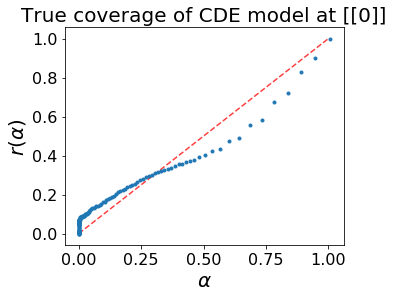

In [127]:
figplus_truth[0]

In [171]:
alpha_range = np.array(figplus_truth[1].hpd_pred)
alpha_range.sort()

In [174]:
figplus = local_pp_plot(x_train=x_test.reshape(-1,1), pit_train=hpd_values,
                    x_test=[(0,)],
                    alphas=alpha_range, 
                    clf_name='MLP',
                    confidence_bands=False, conf_alpha=0.05,
                    n_trials=100, figsize=(5,4),return_data = False
                   )



100% (200 of 200) |######################| Elapsed Time: 0:02:06 Time:  0:02:06


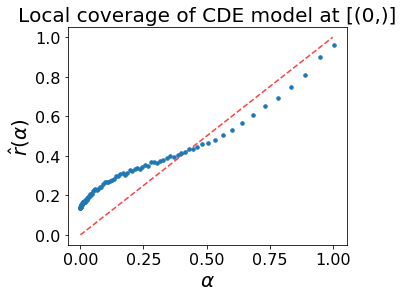

In [175]:
figplus[0].figure

In [184]:
df = pd.DataFrame(figplus[2], columns = ["hpd_pred", "hpd_fit"])

df.tail()

,hpd_pred,hpd_fit
195,0.782936,0.694395
196,0.836227,0.746866
197,0.891164,0.811192
198,0.947810,0.900274
199,1.005025,0.959232


### both visualized together

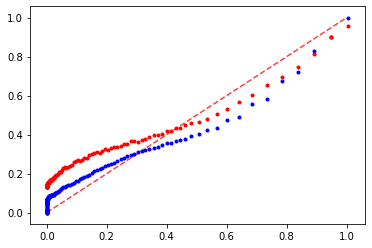

In [180]:

fig, ax = plt.subplots()
ax.scatter(x= figplus_truth[1].hpd_pred, y = figplus_truth[1].hpd_truth,
          color ="b", marker = ".")
ax.scatter(x = df.hpd_pred, y = df.hpd_fit, 
           color = "r", marker = ".")
lims = [0,1]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


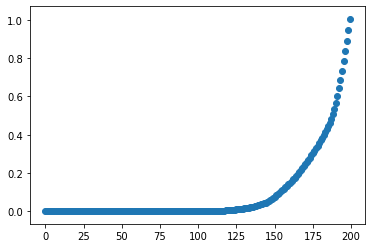

In [190]:
order = np.array(figplus_truth[1].hpd_pred).argsort()


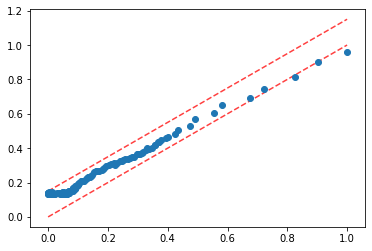

In [212]:
plt.scatter(figplus_truth[1].hpd_truth[order], df.hpd_fit)
lims = [0,1]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)


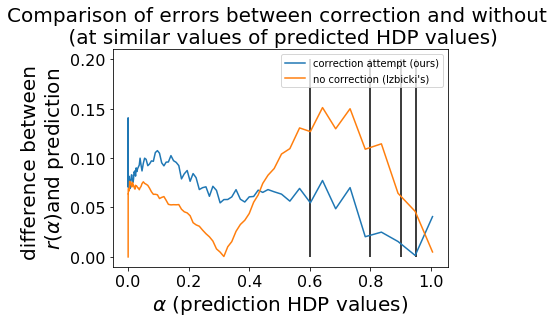

In [244]:
fig, ax = plt.subplots()
ax.plot(np.array(figplus_truth[1].hpd_pred[order]), 
        np.abs(np.array(figplus_truth[1].hpd_truth[order]) - 
               np.array(df.hpd_fit)),
       label= "correction attempt (ours)")
ax.plot(np.array(figplus_truth[1].hpd_pred[order]), 
        np.abs(np.array(figplus_truth[1].hpd_truth[order]) - 
               np.array(figplus_truth[1].hpd_pred[order])),
       label = "no correction (Izbicki's)")

#ax.vlines(x = 1-np.array([.05,.1,.2,.4]), ymin = 0, ymax = .2)
ax.legend()
plt.title("Comparison of errors between correction and without "+\
          "\n (at similar values of predicted HDP values)", fontsize=20)
plt.xlabel(r'$\alpha$ (prediction HDP values)', fontsize=20)
plt.ylabel("difference between \n" + r'$r(\alpha)$' +\
           "and prediction", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)


I'll need to think about whether we care more about the lower levels of $\alpha$ or the higher levels... (and what they really mean). I think we care about the higher end $\alpha$ values that we're doing better on. I'm not actually sure the same store is not true throughout.

### multiple values of x

In [313]:
x_vec = []
hpd_pred = []
hpd_truth = []
for x_idx, x_val in enumerate(np.linspace(0,1,50)):
    figplus_truth = local_pp_plot_truth(x_test = np.array([(x_val,)]), 
                            model = model,
                            y_n_grid=200, return_data = True)

    
    x_vec += [x_val]*200
    hpd_pred += list(figplus_truth.hpd_pred)
    hpd_truth += list(figplus_truth.hpd_truth)
data_truth = pd.DataFrame(data = {"x":x_vec,
                                  "hpd_pred": hpd_pred,
                                  "hpd_truth": hpd_truth})


data_truth_dict = {x_inner:data_truth[data_truth.x == x_inner] for x_inner in np.linspace(0,1,50)}


In [300]:
local_data_out = local_pp_plot_data(x_train.reshape((-1,1)), 
                                    pit_train = hpd_values, 
                                    x_test = np.linspace(0,1,50).reshape((-1,1)),
                                    alphas = np.linspace(0,.999,101))

100% (101 of 101) |######################| Elapsed Time: 0:00:56 Time:  0:00:56


In [301]:
local_data_out.x = [out[0] for out in local_data_out.x]

In [305]:
local_x_dict = {x_inner:local_data_out[local_data_out.x == x_inner] for x_inner in np.linspace(0,1,50)}

In [360]:
import scipy 
def linear_extrapolate(x, y, x_new):
    f = scipy.interpolate.interp1d(x,y)
    return(f(x_new))

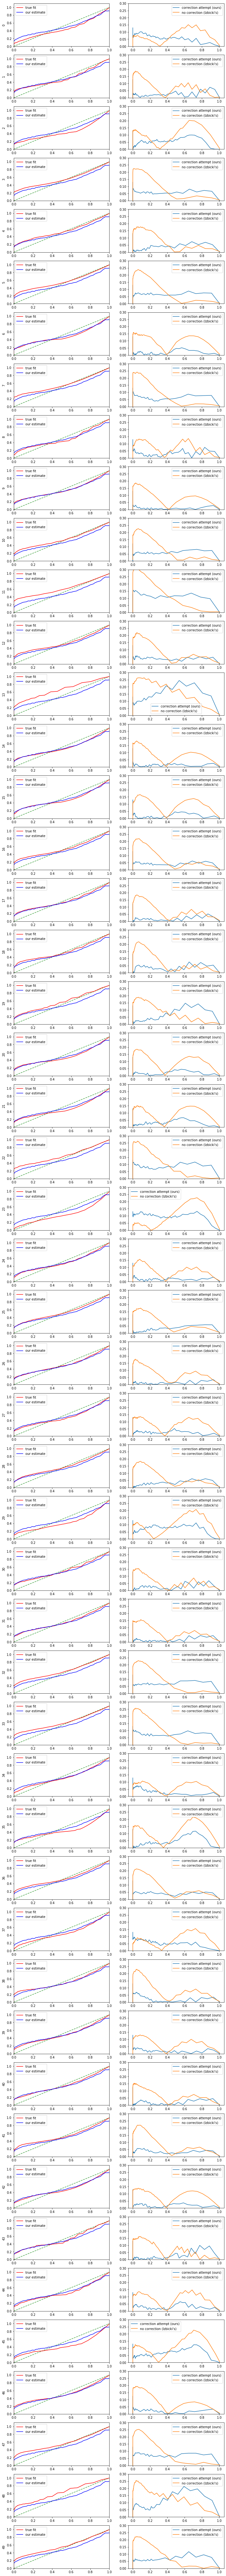

In [482]:
fig, ax = plt.subplots(nrows=50, ncols = 2, figsize = (12,150))

we_r_better = []
yy_vals_we_r_better = []
x_idx_vec = []
yy_vals_below = []
yy_vals_above = []
 
for x_idx, x_val in enumerate(np.linspace(0,1,50)):
    inner_truth = data_truth_dict[x_val]
    inner_smooth = local_x_dict[x_val]
    
    xx = np.array(inner_truth.hpd_pred)
    yy = np.array(inner_truth.hpd_truth)
    xx_idx = xx.argsort()
    ax[x_idx,0].plot(xx[xx_idx], yy[xx_idx],
              "r-", label = "true fit")
    xx2 = np.array(inner_smooth.alpha)
    yy2 = np.array(inner_smooth.rhat)
    xx2_idx = xx2.argsort()
    ax[x_idx,0].plot(xx2[xx2_idx], yy2[xx2_idx], 
               "b-", label = "our estimate")
    lims = [0,1]
    ax[x_idx,0].plot(lims, lims, 'g--', alpha=0.75, zorder=0)
    ax[x_idx,0].legend(loc = "upper left")
    ax[x_idx,0].set_ylim(0,1.1)
    ax[x_idx,0].set_xlim(0,1)
    ax[x_idx,0].set_ylabel(x_idx)
    
    # compared to optimal
    yy2_update = linear_extrapolate([0] + list(xx2) + [1,1.1],[0] + list(yy2) + [1,1], xx)
    
    diff_dz = np.abs(yy2_update-yy)
    diff_iz = np.abs(xx-yy)
    
    ax[x_idx,1].plot(xx[xx_idx], 
                     diff_dz[xx_idx],
                     label= "correction attempt (ours)")
    ax[x_idx,1].plot(xx[xx_idx], diff_iz[xx_idx],
           label = "no correction (Izbicki's)")
    ax[x_idx,1].legend()
    ax[x_idx,1].set_ylim(0,.3)
    
    
    we_r_better += list(diff_iz[xx_idx] >= diff_dz[xx_idx])
    yy_vals = list(xx[xx_idx])
    yy_low = [-.01] + yy_vals[:(len(yy_vals)-1)]
    yy_high = yy_vals[1:] + [1.01]
    
    yy_vals_we_r_better += yy_vals
    
    yy_vals_below += [(yy_vals[i] + yy_low[i])/2 for i in range(len(yy_vals))]
    yy_vals_above += [(yy_vals[i] + yy_high[i])/2 for i in range(len(yy_vals))]

    x_idx_vec += [x_idx]*xx[xx_idx].shape[0]
    
we_r_better_df = pd.DataFrame(data = {"better": we_r_better,
                                     "yy_grid": yy_vals_we_r_better,
                                      "yy_grid_above": yy_vals_above,
                                      "yy_grid_below": yy_vals_below,
                                     "x_idx": x_idx_vec})

In [483]:
we_r_better_df.head()

,better,yy_grid,yy_grid_above,yy_grid_below,x_idx
0,False,0.0,0.0,-0.005,0
1,False,0.0,0.0,0.000,0
2,False,0.0,0.0,0.000,0
3,False,0.0,0.0,0.000,0
4,False,0.0,0.0,0.000,0


In [ ]:
import plotnine as p9

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


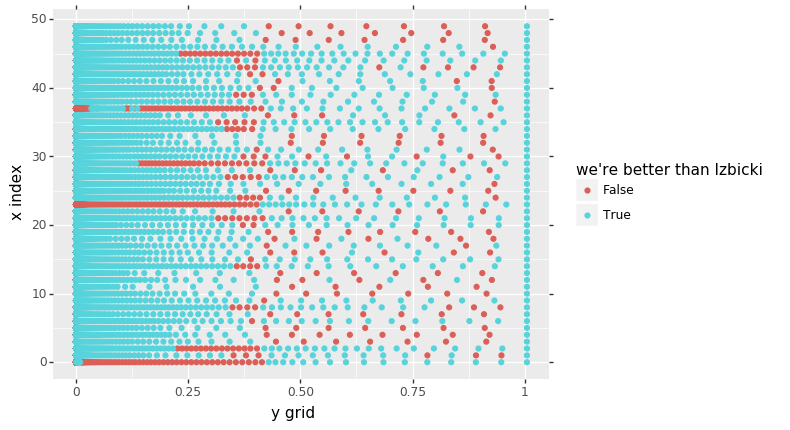

<ggplot: (-9223363263057131811)>

In [484]:
p9.ggplot(we_r_better_df) +\
    p9.geom_point(p9.aes(x = "yy_grid", y = "x_idx", color = "better")) +\
    p9.labs(x = "y grid", y = "x index", color = "we're better than Izbicki")

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


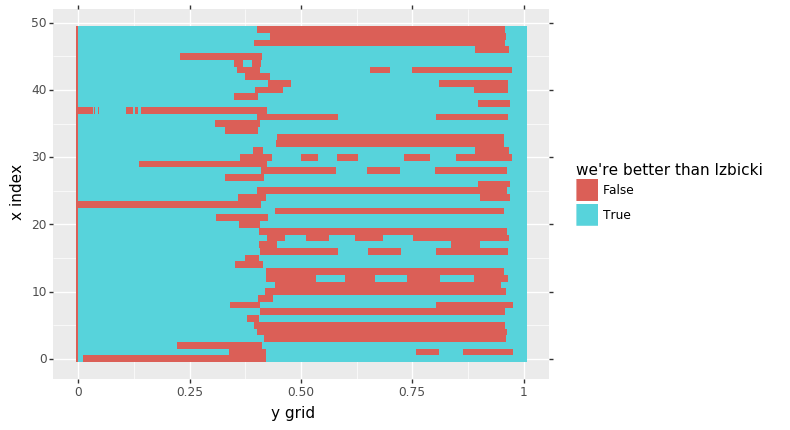

<ggplot: (8773822863536)>

In [487]:
we_r_better_df["x_idx_below"] = we_r_better_df.x_idx - .5
we_r_better_df["x_idx_above"] = we_r_better_df.x_idx + .5

p9.ggplot(we_r_better_df) +\
    p9.geom_rect(p9.aes(xmin = "yy_grid_below",
                        xmax = "yy_grid_above", 
                        ymin = "x_idx_below",
                        ymax = "x_idx_above", fill = "better")) +\
    p9.labs(x = "y grid", y = "x index", fill = "we're better than Izbicki")

# "conformal" approach